##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bayesian Gaussian Mixture Model and Hamiltonian MCMC

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>



In this colab we'll explore sampling from the posterior of a Bayesian Gaussian Mixture Model (BGMM) using only TensorFlow Probability primitives.

## Model

For $k\in\{1,\ldots, K\}$ mixture components each of dimension $D$, we'd like to model $i\in\{1,\ldots,N\}$ iid samples using the following Bayesian Gaussian Mixture Model:

$$\begin{align*}
\theta &\sim \text{Dirichlet}(\text{concentration}=\alpha_0)\\
\mu_k &\sim \text{Normal}(\text{loc}=\mu_{0k}, \text{scale}=I_D)\\
T_k &\sim \text{Wishart}(\text{df}=5, \text{scale}=I_D)\\
Z_i &\sim \text{Categorical}(\text{probs}=\theta)\\
Y_i &\sim \text{Normal}(\text{loc}=\mu_{z_i}, \text{scale}=T_{z_i}^{-1/2})\\
\end{align*}$$

Note, the `scale` arguments all have `cholesky` semantics. We use this convention because it is that of TF Distributions (which itself uses this convention in part because it is computationally advantageous).

Our goal is to generate samples from the posterior:

$$p\left(\theta, \{\mu_k, T_k\}_{k=1}^K \Big| \{y_i\}_{i=1}^N, \alpha_0, \{\mu_{ok}\}_{k=1}^K\right)$$

Notice that $\{Z_i\}_{i=1}^N$ is not present--we're interested in only those random variables which don't scale with $N$.  (And luckily there's a TF distribution which handles marginalizing out $Z_i$.)

It is not possible to directly sample from this distribution owing to a computationally intractable normalization term.

[Metropolis-Hastings algorithms](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) are technique for for sampling from intractable-to-normalize distributions.

TensorFlow Probability offers a number of MCMC options, including several based on Metropolis-Hastings. In this notebook, we'll use [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo)  (`tfp.mcmc.HamiltonianMonteCarlo`). HMC is often a good choice because it can converge rapidly, samples the state space jointly (as opposed to coordinatewise), and leverages one of TF's virtues: automatic differentiation. That said, sampling from a BGMM posterior might actually be better done by other approaches, e.g., [Gibb's sampling](https://en.wikipedia.org/wiki/Gibbs_sampling).

In [2]:
# !pip install -q tensorfl`ow-probability

In [3]:
%matplotlib inline

# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

import functools

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import seaborn as sns; sns.set_context('notebook')

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
plt.rcParams['figure.figsize'] = (20,10)

In [4]:
def session_options(enable_gpu_ram_resizing=True):
  """Convenience function which sets common `tf.Session` options."""
  config = tf.ConfigProto()
  config.log_device_placement = True
  if enable_gpu_ram_resizing:
    # `allow_growth=True` makes it possible to connect multiple colabs to your
    # GPU. Otherwise the colab malloc's all GPU ram.
    config.gpu_options.allow_growth = True
  return config

def reset_sess(config=None):
  """Convenience function to create the TF graph and session, or reset them."""
  if config is None:
    config = session_options()
  tf.reset_default_graph()
  global sess
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession(config=config)

reset_sess()

Before actually building the model, we'll need to define a new type of distribution.  From the model specification above, its clear we're parameterizing the MVN with an inverse covariance matrix, i.e.,  [precision matrix](https://en.wikipedia.org/wiki/Precision_(statistics%29).  To accomplish this in TF,  we'll need to roll out our `Bijector`.  This `Bijector` will use the forward transformation:

- `Y =`  [`tf.matrix_triangular_solve`](https://www.tensorflow.org/api_docs/python/tf/matrix_triangular_solve)`(tf.matrix_transpose(chol_precision_tril), X, adjoint=True) + loc`.

And the `log_prob` calculation is just the inverse, i.e.:

- `X =` [`tf.matmul`](https://www.tensorflow.org/api_docs/python/tf/matmul)`(chol_precision_tril, X - loc, adjoint_a=True)`.

Since all we need for HMC is `log_prob`, this means we avoid ever calling `tf.matrix_triangular_solve` (as would be the case for `tfd.MultivariateNormalTriL`). This is advantageous since `tf.matmul` is usually faster owing to better cache locality.


In [5]:
class MVNCholPrecisionTriL(tfd.TransformedDistribution):
  """MVN from loc and (Cholesky) precision matrix."""

  def __init__(self, loc, chol_precision_tril, name=None):
    super(MVNCholPrecisionTriL, self).__init__(
        distribution=tfd.Independent(tfd.Normal(tf.zeros_like(loc),
                                                scale=tf.ones_like(loc)),
                                     reinterpreted_batch_ndims=1),
        bijector=tfb.Chain([
            tfb.Affine(shift=loc),
            tfb.Invert(tfb.Affine(scale_tril=chol_precision_tril,
                                  adjoint=True)),
        ]),
        name=name)

**TODO** Analyze the math of the above code

The `tfd.Independent` distribution turns independent draws of one distribution, into a multivariate distribution with statistically independent coordinates. In terms of computing `log_prob`, this "meta-distribution" manifests as a simple sum over the event dimension(s).

Also notice that we took the `adjoint` ("transpose") of the scale matrix. This is because if precision is inverse covariance, i.e., $P=C^{-1}$ and if $C=AA^\top$, then $P=BB^{\top}$ where $B=A^{-\top}$.

Since this distribution is kind of tricky, let's quickly verify that our `MVNCholPrecisionTriL` works as we think it should.

In [6]:
def compute_sample_stats(d, seed=42, n=int(1e6)):
  x = d.sample(n, seed=seed)
  sample_mean = tf.reduce_mean(x, axis=0, keepdims=True)
  s = x - sample_mean
  sample_cov = tf.matmul(s, s, adjoint_a=True) / tf.cast(n, s.dtype)
  sample_scale = tf.cholesky(sample_cov)
  sample_mean = sample_mean[0]
  return [
      sample_mean,
      sample_cov,
      sample_scale,
  ]

dtype = np.float32
true_loc = np.array([1., -1.], dtype=dtype)
true_chol_precision = np.array([[1., 0.],
                                [2., 8.]],
                               dtype=dtype)
true_precision = np.matmul(true_chol_precision, true_chol_precision.T)
true_cov = np.linalg.inv(true_precision)

d = MVNCholPrecisionTriL(
    loc=true_loc,
    chol_precision_tril=true_chol_precision)

[
    sample_mean_,
    sample_cov_,
    sample_scale_,
] = sess.run(compute_sample_stats(d))

print('true mean:', true_loc)
print('sample mean:', sample_mean_)
print('true cov:\n', true_cov)
print('sample cov:\n', sample_cov_)

true mean: [ 1. -1.]
sample mean: [ 1.0002806 -1.000105 ]
true cov:
 [[ 1.0625   -0.03125 ]
 [-0.03125   0.015625]]
sample cov:
 [[ 1.0641283  -0.03126172]
 [-0.03126172  0.01559312]]


Since the sample mean and covariance are close to the true mean and covariance, it seems like the distribution is correctly implemented. Now, we'll use `MVNCholPrecisionTriL` and  stock`tfp.distributions` to specify the BGMM prior random variables:

In [7]:
dtype = np.float32
dims = 2
components = 3

Prior distribution

In [8]:
rv_mix_probs = tfd.Dirichlet(
    concentration=np.ones(components, dtype) / 10.,
    name='rv_mix_probs')

rv_loc = tfd.Independent(
    tfd.Normal(
        loc=np.stack([
            -np.ones(dims, dtype),
            np.zeros(dims, dtype),
            np.ones(dims, dtype),
        ]),
        scale=tf.ones([components, dims], dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_loc')

rv_precision = tfd.Wishart(
    df=5,
    scale_tril=np.stack([np.eye(dims, dtype=dtype)]*components),
    input_output_cholesky=True,
    name='rv_precision')

Using the three random variables defined above, we can now specify the joint log probability function. To do this we'll use `tfd.MixtureSameFamily` to automatically integrate out the categorical $\{Z_i\}_{i=1}^N$ draws.

In [9]:
def joint_log_prob(observations, mix_probs, loc, chol_precision):
  """BGMM with priors: loc=Normal, precision=Inverse-Wishart, mix=Dirichlet.

  Args:
    observations: `[n, d]`-shaped `Tensor` representing Bayesian Gaussian
      Mixture model draws. Each sample is a length-`d` vector.
    mix_probs: `[K]`-shaped `Tensor` representing random draw from
      `SoftmaxInverse(Dirichlet)` prior.
    loc: `[K, d]`-shaped `Tensor` representing the location parameter of the
      `K` components.
    chol_precision: `[K, d, d]`-shaped `Tensor` representing `K` lower
      triangular `cholesky(Precision)` matrices, each being sampled from
      a Wishart distribution.

  Returns:
    log_prob: `Tensor` representing joint log-density over all inputs.
  """
  rv_observations = tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=mix_probs),
      components_distribution=MVNCholPrecisionTriL(
          loc=loc,
          chol_precision_tril=chol_precision))
  log_prob_parts = [
      rv_observations.log_prob(observations), # Sum over samples.
      rv_mix_probs.log_prob(mix_probs)[..., tf.newaxis],
      rv_loc.log_prob(loc),                   # Sum over components.
      rv_precision.log_prob(chol_precision),  # Sum over components.
  ]
  sum_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1), axis=-1)
  # Note: for easy debugging, uncomment the following:
  # sum_log_prob = tf.Print(sum_log_prob, log_prob_parts)
  return sum_log_prob

Notice that this function internally defines a new random variable. This is necessary since the `observations` RV depends on samples from the RVs defined further above.

## Generate "Training" Data

For this demo, we'll sample some random data.

In [10]:
num_samples = 1000
true_loc = np.array([[-2, -2],
                     [0, 0],
                     [2, 2]], dtype)
random = np.random.RandomState(seed=42)

true_hidden_component = random.randint(0, components, num_samples)
observations = (true_loc[true_hidden_component] +
                random.randn(num_samples, dims).astype(dtype))

## Bayesian Inference using HMC

Now that we've used TFD to **specify our model** and obtained some observed data, we have all the necessary pieces to run HMC.

To do this, we'll use a [partial application](https://en.wikipedia.org/wiki/Partial_application) to "pin down" the things we don't want to sample. In this case that means we need only pin down `observations`. (The hyper-parameters are already baked in to the prior distributions and not part of the `joint_log_prob` function signature.)

In [12]:
unnormalized_posterior_log_prob = functools.partial(joint_log_prob, observations)

In [13]:
initial_state = [
    tf.fill([components],
            value=np.array(1. / components, dtype),
            name='mix_probs'),
    tf.constant(np.array([[-2, -2],
                          [0, 0],
                          [2, 2]], dtype),
                name='loc'),
    tf.eye(dims, batch_shape=[components], dtype=dtype, name='chol_precision'),
]

intial state is the initalization of parameters. In other words, state are **generated samples**.

### Unconstrained Representation

Hamiltonian Monte Carlo (HMC) requires the target log-probability function be differentiable with respect to its arguments.  Furthermore, HMC can exhibit dramatically higher statistical efficiency if the state-space is unconstrained.

This means we'll have to work out two main issues when sampling from the BGMM posterior:

1. $\theta$ represents a discrete probability vector, i.e., must be such that $\sum_{k=1}^K \theta_k = 1$ and $\theta_k>0$.
2. $T_k$ represents an inverse covariance matrix, i.e., must be such that $T_k \succ 0$, i.e., is [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix).


To address this requirement we'll need to:

1. transform the constrained variables to an unconstrained space
2. run the MCMC in unconstrained space
3. transform the unconstrained variables back to the constrained space.

As with `MVNCholPrecisionTriL`, we'll use [`Bijector`s](https://www.tensorflow.org/api_docs/python/tf/distributions/bijectors/Bijector) to transform random variables to unconstrained space.

- The [`Dirichlet`](https://en.wikipedia.org/wiki/Dirichlet_distribution) is transformed to unconstrained space via the [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

- Our precision random variable is a distribution over postive semidefinite matrices. To unconstrain these we'll use the `FillTriangular` and `TransformDiagonal` bijectors.  These convert vectors to lower-triangular matrices and ensure the diagonal is positive. The former is useful because it enables sampling only $d(d+1)/2$ floats rather than $d^2$.

In [14]:
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.Identity(),
    tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus()),
        tfb.FillTriangular(),
    ])]

In [15]:
[mix_probs, loc, chol_precision], kernel_results = tfp.mcmc.sample_chain(
    num_results=2000,
    num_burnin_steps=500,
    current_state=initial_state,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            step_size=0.065,
            num_leapfrog_steps=5),
        bijector=unconstraining_bijectors))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [16]:
acceptance_rate = tf.reduce_mean(tf.to_float(kernel_results.inner_results.is_accepted))
mean_mix_probs = tf.reduce_mean(mix_probs, axis=0)
mean_loc = tf.reduce_mean(loc, axis=0)
mean_chol_precision = tf.reduce_mean(chol_precision, axis=0)

Note: through trial-and-error we've predetermined the `step_size` and `num_leapfrog_steps` to approximately achieve an [asymptotically optimal rate of 0.651](https://arxiv.org/abs/1001.4460). For a technique to do this automatically, see the examples section in `help(tfp.mcmc.HamiltonianMonteCarlo)`.

We'll now execute the chain and print the posterior means.

In [17]:
[
    acceptance_rate_,
    mean_mix_probs_,
    mean_loc_,
    mean_chol_precision_,
    mix_probs_,
    loc_,
    chol_precision_,
] = sess.run([
    acceptance_rate,
    mean_mix_probs,
    mean_loc,
    mean_chol_precision,
    mix_probs,
    loc,
    chol_precision,
])

In [18]:
print('    acceptance_rate:', acceptance_rate_)
print('      avg mix probs:', mean_mix_probs_)
print('\n            avg loc:\n', mean_loc_)
print('\navg chol(precision):\n', mean_chol_precision_)

    acceptance_rate: 0.6495
      avg mix probs: [0.37009734 0.27778584 0.3521164 ]

            avg loc:
 [[-1.8986769  -1.8121194 ]
 [-0.03962456 -0.01476802]
 [ 1.9119028   1.932787  ]]

avg chol(precision):
 [[[ 1.019846    0.        ]
  [-0.03334109  0.98887575]]

 [[ 1.2004799   0.        ]
  [ 0.18999663  1.0108514 ]]

 [[ 0.9922289   0.        ]
  [-0.116994    0.9711073 ]]]


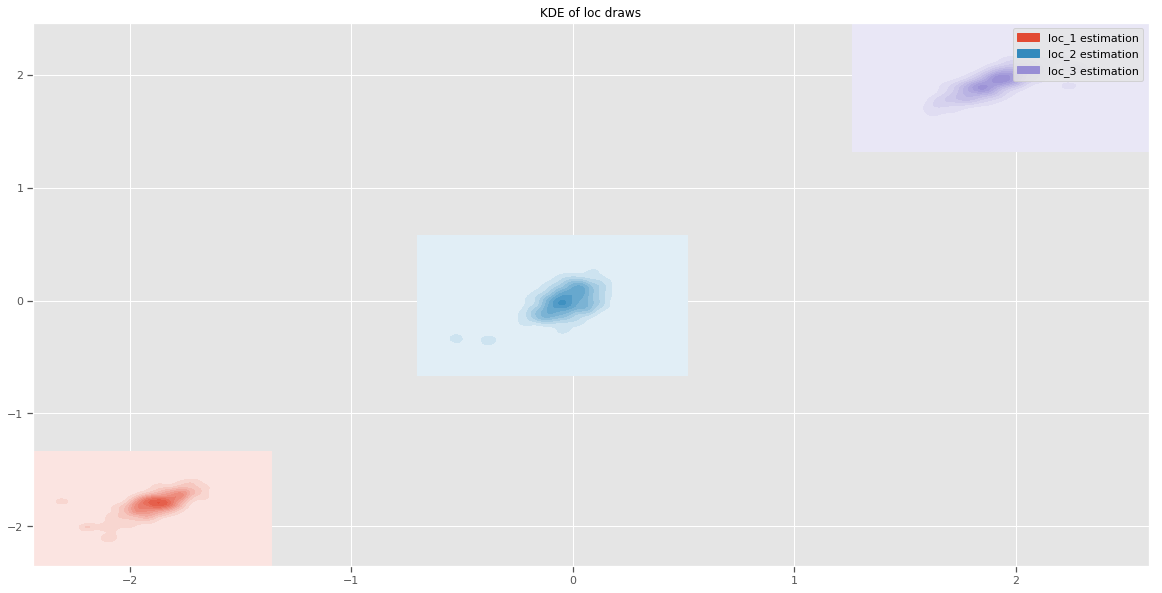

In [39]:
sns.kdeplot(loc_[:,0,0], loc_[:,0,1], shade=True, label='loc_1 estimation')
sns.kdeplot(loc_[:,1,0], loc_[:,1,1], shade=True, label='loc_2 estimation')
sns.kdeplot(loc_[:,2,0], loc_[:,2,1], shade=True, label='loc_3 estimation')
# sns.scatterplot(x=observations[:,0], y=observations[:,1], hue=true_hidden_component, alpha=0.3);
# sns.scatterplot(x=observations[:,0], y=observations[:,1], alpha=0.1, label='data points');
plt.legend()
plt.title('KDE of loc draws');

## Conclusion

This simple colab demonstrated how TensorFlow Probability primitives can be used to build hierarchical Bayesian mixture models.

# Notes

Generate samples from MVN(0, Sigma)
1. Generate Z ~ MVN(0,I)
2. Compute C such that C^T * C = SIGMA (Cholesky decomposition)
3. X = C^T * Z

- https://en.wikipedia.org/wiki/Cholesky_decomposition
- http://www.columbia.edu/~mh2078/MonteCarlo/MCS_Generate_RVars.pdf

Cholesky decomposition $\Sigma = LL^{T}$, where L is lower triangular matrix.

In [20]:
x = np.linspace(0,1,100)

In [21]:
y = x**5 * (1 + x)**3 / 8

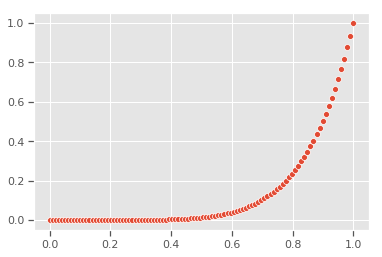

In [22]:
sns.scatterplot(x=x, y=y)